# Import Used Dependancies

In [1]:
!pip install scikit-learn==1.6.0

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils.validation import check_array, check_X_y
from sklearn.base import BaseEstimator, ClassifierMixin

# Read Data

In [2]:
dire = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        dire.append(os.path.join(dirname, filename))
print(dire)

['/kaggle/input/titanic/train.csv', '/kaggle/input/titanic/test.csv', '/kaggle/input/titanic/gender_submission.csv']


In [3]:
train = pd.read_csv(dire[0])
x_test = pd.read_csv(dire[1])
y_test = pd.read_csv(dire[2])

# Explore Data

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We might need to impute the `Age` category, but we have to drop `Cabin` altogether since it's missing way too many entries, so imputing it won't result in a good model (We can drop `Age` if we find out imputing it is not efficient too, since it's missing more than 100 entries as well)

We might also need to drop:
- `Name`
- `Ticket`

Since (most likely) they are not going to be useful and just confuse our model more

In [7]:
train[["Survived"]].value_counts()

Survived
0           549
1           342
Name: count, dtype: int64

This imbalacement may cause our model to predict `1` as `0` more often, we'll see how to fix this if it turns out to be a problem

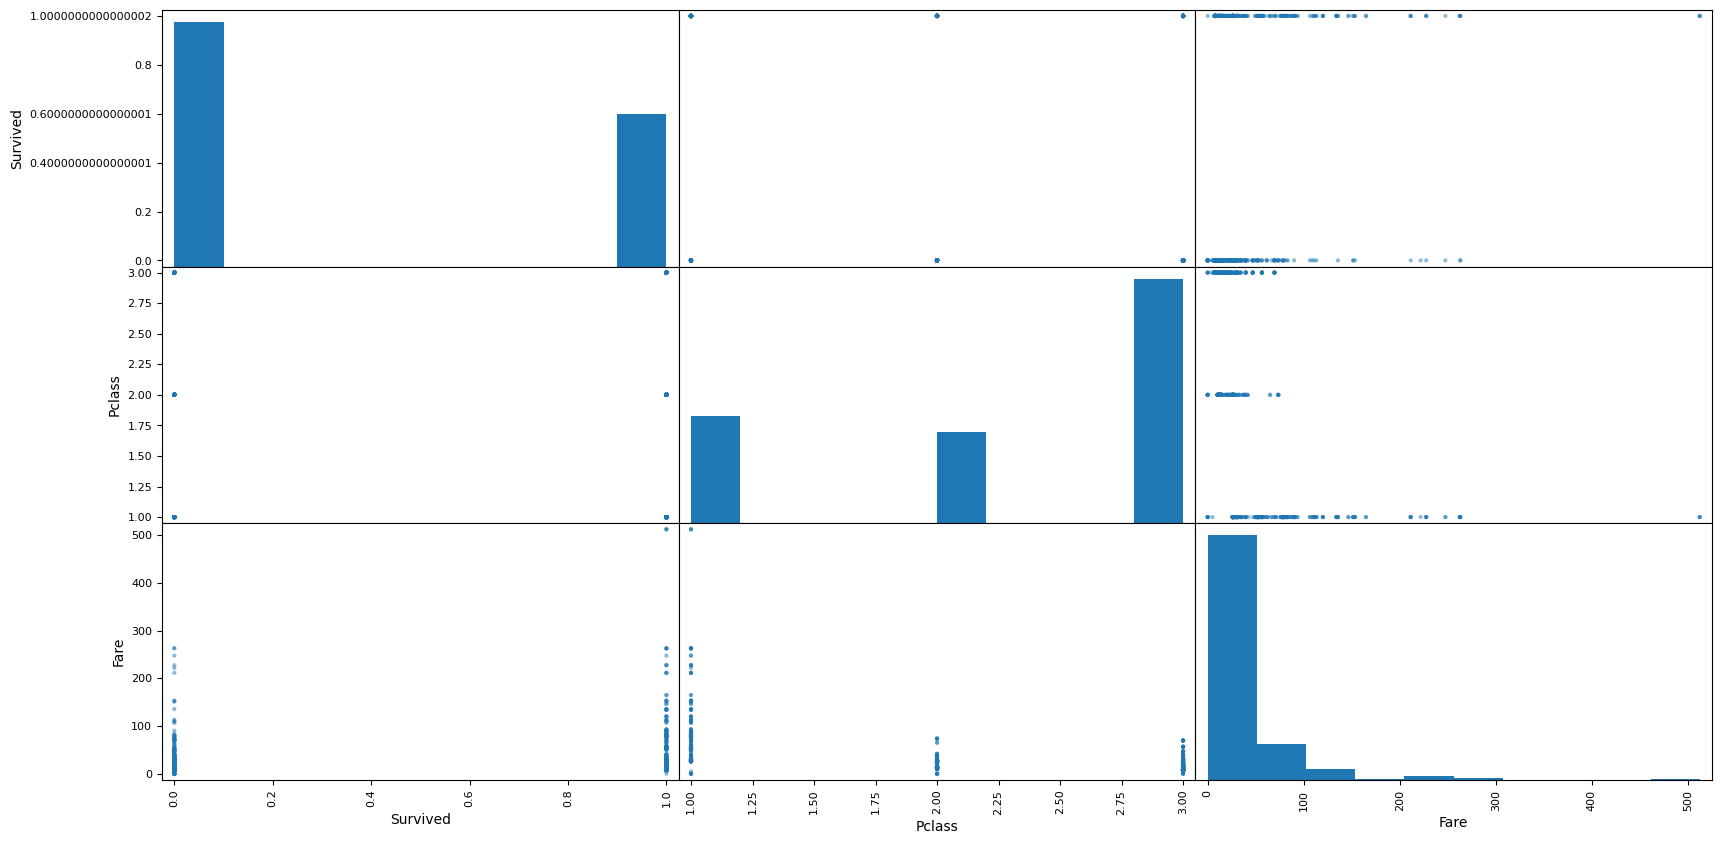

In [8]:
pd.plotting.scatter_matrix(train[["Survived", "Sex", "Pclass", "Fare", 'Embarked']], figsize=(20, 10))
plt.show()

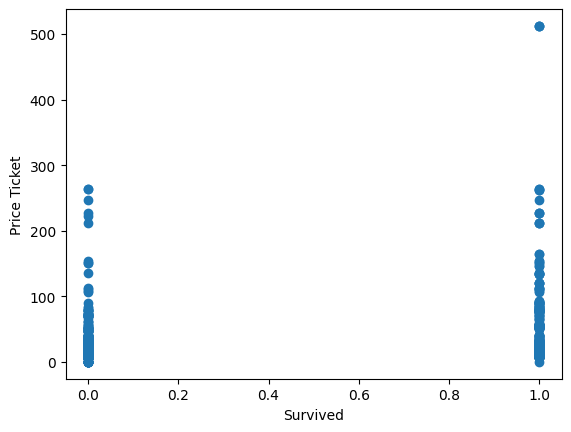

In [9]:
plt.scatter(train[["Survived"]], train[["Fare"]])
plt.xlabel("Survived")
plt.ylabel("Price Ticket")
plt.show()

With a single outlier, it seems that there's almost an equal number of survivors and non-survivors when we check the price ticket (However the number of survivors is more in the 100-150 range, and less in the 200-270 range)

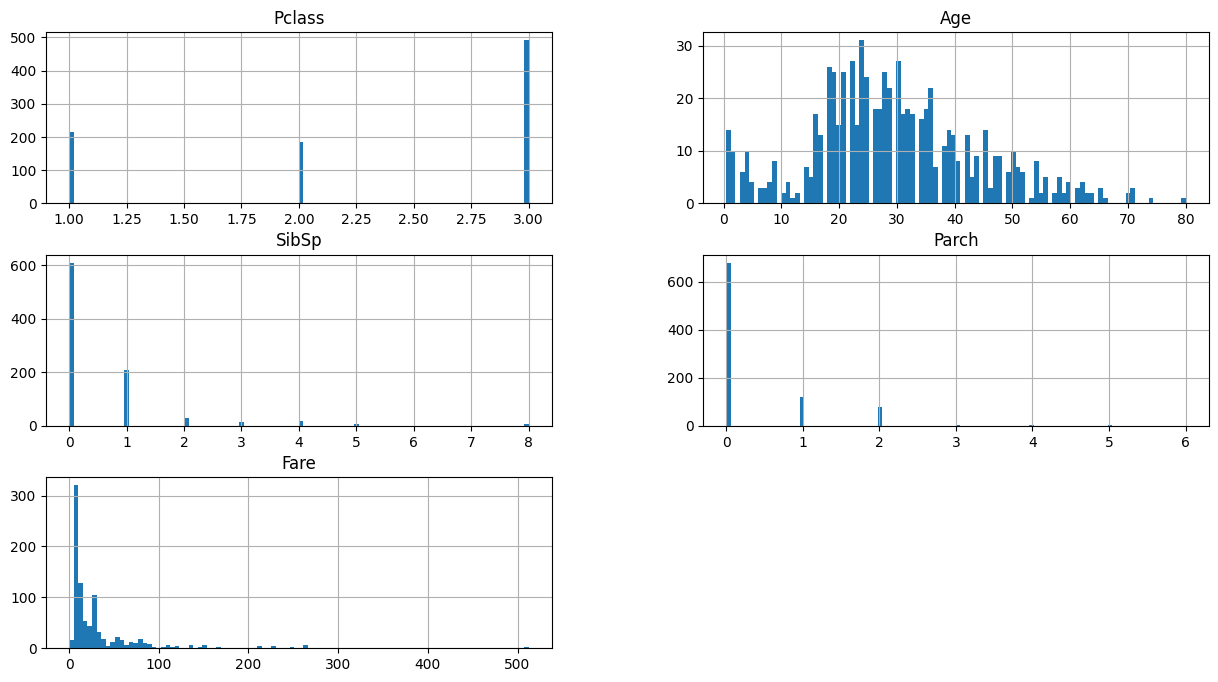

In [10]:
train.drop(["PassengerId", "Survived"], axis=1).hist(figsize=(15, 8), bins=100)
plt.show()

# Drop Useless Features

For now, we'll drop `Cabin`, `Name`, and `Ticket`, untill we're more confident regarding what to do with `Age`

In [11]:
train.drop(["Cabin","Name", "Ticket"], axis=1, inplace=True)
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


# Encode Categorical Data

We need to encode `Sex` and `Embarked`

In [12]:
imputer = SimpleImputer(strategy="most_frequent")
train[["Embarked"]] = imputer.fit_transform(train[['Embarked']])

ord_enc = OrdinalEncoder()
train[["Sex", "Embarked"]] = ord_enc.fit_transform(train[["Sex", "Embarked"]])

In [13]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1.0,22.0,1,0,7.2500,2.0
1,2,1,1,0.0,38.0,1,0,71.2833,0.0
2,3,1,3,0.0,26.0,0,0,7.9250,2.0
3,4,1,1,0.0,35.0,1,0,53.1000,2.0
4,5,0,3,1.0,35.0,0,0,8.0500,2.0


# Get Correlation Matrix

In [14]:
train.corr().style.background_gradient(cmap='coolwarm')

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,1.000000,-0.005007,-0.035144,0.042939,0.036847,-0.057527,-0.001652,0.012658,0.013128
Survived,-0.005007,1.000000,-0.338481,-0.543351,-0.077221,-0.035322,0.081629,0.257307,-0.167675
Pclass,-0.035144,-0.338481,1.000000,0.131900,-0.369226,0.083081,0.018443,-0.549500,0.162098
Sex,0.042939,-0.543351,0.131900,1.000000,0.093254,-0.114631,-0.245489,-0.182333,0.108262
Age,0.036847,-0.077221,-0.369226,0.093254,1.000000,-0.308247,-0.189119,0.096067,-0.030394
SibSp,-0.057527,-0.035322,0.083081,-0.114631,-0.308247,1.000000,0.414838,0.159651,0.068230
Parch,-0.001652,0.081629,0.018443,-0.245489,-0.189119,0.414838,1.000000,0.216225,0.039798
Fare,0.012658,0.257307,-0.549500,-0.182333,0.096067,0.159651,0.216225,1.000000,-0.224719
Embarked,0.013128,-0.167675,0.162098,0.108262,-0.030394,0.068230,0.039798,-0.224719,1.000000


This shows that:
- The Gender of the passenger is highly correlated to their survival
- Their class is also very correlated, since higher class passengers had easier access to the docks
- Their Fare also has an affect, since it states in an indirect way their class
- It seems like the number of parents/children (ParCh) and the number of siblings/spouses (SibSp) doesn't have as strong a relation as (I) initially thought they would
- Where the passengers embarked also doesn't have a ver strong correlation to their survival, but i think it should still be used
- Their age is not as related as I thought it would be, but I do believe in an indirect way, the age of the passenger affects their survival rate, since that affects their agility, and ability to last in such harsh weathers

# Impute Missing Data

In [15]:
imputer_age = SimpleImputer(strategy="mean")
train[["Age"]] = imputer_age.fit_transform(train[["Age"]])

# Feature Engineering

In [16]:
train[["FamilyMembers"]] = train[["SibSp"]].to_numpy() + train[["Parch"]].to_numpy()

scaler = MinMaxScaler()
train[["SibSp", "Parch"]] = scaler.fit_transform(train[["SibSp", "Parch"]])

train[["Survived", "FamilyMembers"]].corr().style.background_gradient(cmap='coolwarm')

,Survived,FamilyMembers
Survived,1.000000,0.016639
FamilyMembers,0.016639,1.000000


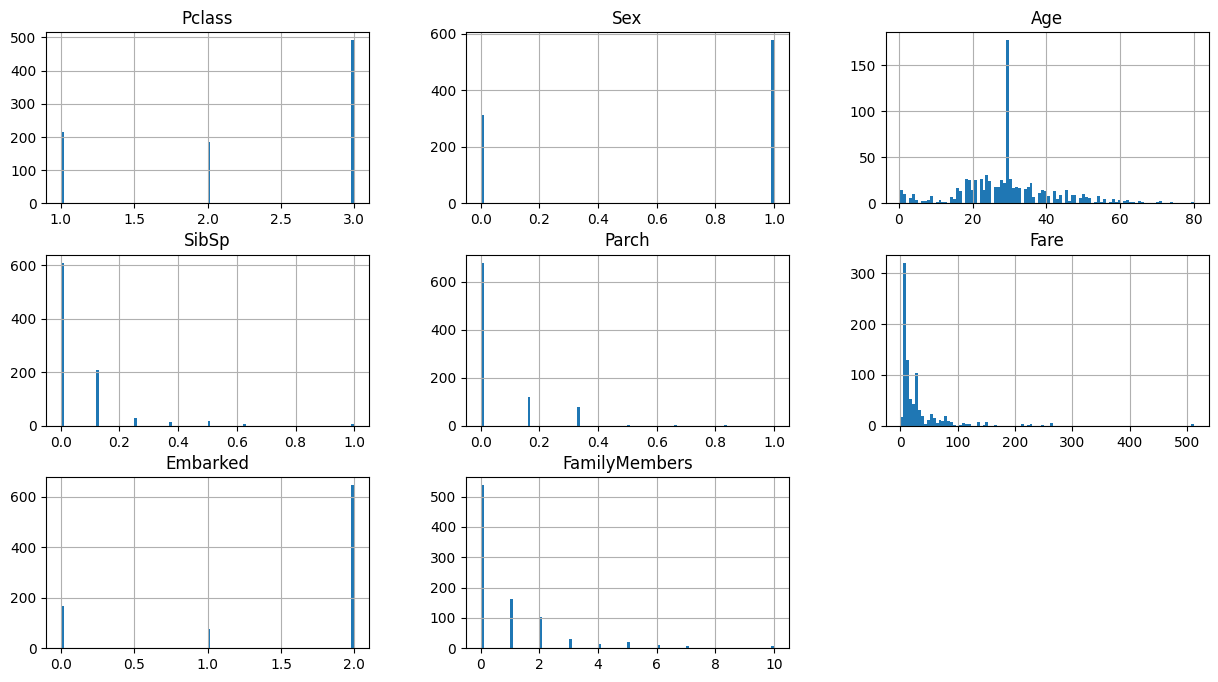

In [17]:
train.drop(["PassengerId", "Survived"], axis=1).hist(figsize=(15, 8), bins=100)
plt.show()

# Train Model

## Training Logistic Regression Model

In [18]:
x_train, y_train = train.drop(["Survived", "PassengerId"], axis=1), train[["Survived"]]
x_test.drop("PassengerId", axis=1, inplace=True)

In [19]:
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(x_train.to_numpy(), y_train.to_numpy().ravel())

LogisticRegression(max_iter=500)

## Create a data pipeline for new input

In [20]:
enc_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder()
)

standardscale_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
    
)
scaler_pipeline = make_pipeline(
    SimpleImputer(strategy="mean"),
    MinMaxScaler()
)

preprocessing = make_column_transformer(
    (enc_pipeline, ["Sex", "Embarked"]),
    (standardscale_pipeline, ['Age', 'Fare']),
    (scaler_pipeline, ["SibSp", "Parch"]),
    remainder="passthrough"
)

In [21]:
x_test.drop(["Cabin", "Name", "Ticket"], axis=1, inplace=True)
x_test[["FamilyMembers"]] = x_test[["SibSp"]].to_numpy() + x_test[["Parch"]].to_numpy()
pre_processed = preprocessing.fit_transform(x_test)
pre_processed

array([[ 1.        ,  1.        ,  0.38623105, ...,  0.        ,
         3.        ,  0.        ],
       [ 0.        ,  2.        ,  1.37137004, ...,  0.        ,
         3.        ,  1.        ],
       [ 1.        ,  1.        ,  2.55353683, ...,  0.        ,
         2.        ,  0.        ],
       ...,
       [ 1.        ,  2.        ,  0.70147553, ...,  0.        ,
         3.        ,  0.        ],
       [ 1.        ,  2.        , -0.20485235, ...,  0.        ,
         3.        ,  0.        ],
       [ 1.        ,  0.        , -0.20485235, ...,  0.11111111,
         3.        ,  2.        ]])

## Checking the model's performance

In [22]:
pred_test = log_reg.predict(pre_processed)
pred_train = log_reg.predict(x_train.to_numpy())

print(f"Test Accuracy: {accuracy_score(y_test[['Survived']], pred_test) * 100:.2f}%",
      f"Test Precision: {precision_score(y_test[['Survived']], pred_test) * 100:.2f}%",
      f"Test Recall: {recall_score(y_test[['Survived']], pred_test) * 100:.2f}%",
      f"Test F1: {f1_score(y_test[['Survived']], pred_test) * 100:.2f}%",
sep="\n")
print("__________________________\n")

print(f"Train Accuracy: {accuracy_score(y_train, pred_train) * 100:.2f}%",
      f"Train Precision: {precision_score(y_train, pred_train) * 100:.2f}%",
      f"Train Recall: {recall_score(y_train, pred_train) * 100:.2f}%",
      f"Train F1: {f1_score(y_train, pred_train) * 100:.2f}%",
sep="\n")

Test Accuracy: 59.09%
Test Precision: 43.54%
Test Recall: 42.11%
Test F1: 42.81%
__________________________

Train Accuracy: 80.36%
Train Precision: 76.68%
Train Recall: 70.18%
Train F1: 73.28%


# Improving the model

## Adjusting Class Weights

In [23]:
log_reg_with_class_weights = LogisticRegression(class_weight="balanced", max_iter=500)
log_reg_with_class_weights.fit(x_train.to_numpy(), y_train.to_numpy().ravel())

weighted_pred_test = log_reg_with_class_weights.predict(pre_processed)
weighted_pred_train = log_reg_with_class_weights.predict(x_train.to_numpy())

print(f"Test Accuracy: {accuracy_score(y_test[['Survived']], weighted_pred_test) * 100:.2f}%",
      f"Test Precision: {precision_score(y_test[['Survived']], weighted_pred_test) * 100:.2f}%",
      f"Test Recall: {recall_score(y_test[['Survived']], weighted_pred_test) * 100:.2f}%",
      f"Test F1: {f1_score(y_test[['Survived']], weighted_pred_test) * 100:.2f}%",
sep="\n")
print("__________________________\n")

print(f"Train Accuracy: {accuracy_score(y_train, weighted_pred_train) * 100:.2f}%",
      f"Train Precision: {precision_score(y_train, weighted_pred_train) * 100:.2f}%",
      f"Train Recall: {recall_score(y_train, weighted_pred_train) * 100:.2f}%",
      f"Train F1: {f1_score(y_train, weighted_pred_train) * 100:.2f}%",
sep="\n")

Test Accuracy: 60.53%
Test Precision: 45.81%
Test Recall: 46.71%
Test F1: 46.25%
__________________________

Train Accuracy: 79.01%
Train Precision: 71.12%
Train Recall: 76.32%
Train F1: 73.62%


This model is slightly better than the previous model(Double the recall!), but there's more work to be done

## Undersampling

In [24]:
from imblearn.under_sampling import RandomUnderSampler

UnderSample = RandomUnderSampler(random_state=42)
UnderSample_x_train, UnderSample_y_train = UnderSample.fit_resample(x_train, y_train)
UnderSample_y_train.value_counts()

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Survived
0           342
1           342
Name: count, dtype: int64

In [25]:
undersampled_log_reg = LogisticRegression(max_iter=200)
undersampled_log_reg.fit(UnderSample_x_train.to_numpy(), UnderSample_y_train.to_numpy().ravel())
undersampled_pred_test = undersampled_log_reg.predict(pre_processed)
undersampled_pred_train = undersampled_log_reg.predict(x_train.to_numpy())

print(f"Test Accuracy: {accuracy_score(y_test[['Survived']], undersampled_pred_test) * 100:.2f}%",
      f"Test Precision: {precision_score(y_test[['Survived']], undersampled_pred_test) * 100:.2f}%",
      f"Test Recall: {recall_score(y_test[['Survived']], undersampled_pred_test) * 100:.2f}%",
      f"Test F1: {f1_score(y_test[['Survived']], undersampled_pred_test) * 100:.2f}%",
sep="\n")
print("__________________________\n")

print(f"Train Accuracy: {accuracy_score(y_train, undersampled_pred_train) * 100:.2f}%",
      f"Train Precision: {precision_score(y_train, undersampled_pred_train) * 100:.2f}%",
      f"Train Recall: {recall_score(y_train, undersampled_pred_train) * 100:.2f}%",
      f"Train F1: {f1_score(y_train, undersampled_pred_train) * 100:.2f}%",
sep="\n")

Test Accuracy: 65.31%
Test Precision: 52.00%
Test Recall: 59.87%
Test F1: 55.66%
__________________________

Train Accuracy: 79.35%
Train Precision: 71.01%
Train Recall: 78.07%
Train F1: 74.37%


Okay, Undersampling did better than the original model, but it is not better than calculating class weights (combining both techniques here does nothing since now both are balanced, so both classes get the same importance)

## Oversampling

In [26]:
from imblearn.over_sampling import RandomOverSampler

OverSample = RandomOverSampler(random_state=42)
OverSample_x_train, OverSample_y_train = OverSample.fit_resample(x_train, y_train)
OverSample_y_train.value_counts()

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Survived
0           549
1           549
Name: count, dtype: int64

In [27]:
oversampled_log_reg = LogisticRegression(max_iter=500, class_weight="balanced")
oversampled_log_reg.fit(OverSample_x_train.to_numpy(), OverSample_y_train.to_numpy().ravel())
oversampled_pred_test = oversampled_log_reg.predict(pre_processed)
oversampled_pred_train = oversampled_log_reg.predict(x_train.to_numpy())

print(f"Test Accuracy: {accuracy_score(y_test[['Survived']], oversampled_pred_test) * 100:.2f}%",
      f"Test Precision: {precision_score(y_test[['Survived']], oversampled_pred_test) * 100:.2f}%",
      f"Test Recall: {recall_score(y_test[['Survived']], oversampled_pred_test) * 100:.2f}%",
      f"Test F1: {f1_score(y_test[['Survived']], oversampled_pred_test) * 100:.2f}%",
sep="\n")
print("__________________________\n")

print(f"Train Accuracy: {accuracy_score(y_train, oversampled_pred_train) * 100:.2f}%",
      f"Train Precision: {precision_score(y_train, oversampled_pred_train) * 100:.2f}%",
      f"Train Recall: {recall_score(y_train, oversampled_pred_train) * 100:.2f}%",
      f"Train F1: {f1_score(y_train, oversampled_pred_train) * 100:.2f}%",
sep="\n")

Test Accuracy: 58.85%
Test Precision: 43.24%
Test Recall: 42.11%
Test F1: 42.67%
__________________________

Train Accuracy: 78.79%
Train Precision: 70.96%
Train Recall: 75.73%
Train F1: 73.27%


## Mixing Oversampling and Undersampling

In [28]:
underSample = RandomUnderSampler(random_state=42, sampling_strategy=0.7)
underSample_x_train, underSample_y_train = underSample.fit_resample(x_train, y_train)

overSample = RandomOverSampler(random_state=42)
overSample_x_train, overSample_y_train = overSample.fit_resample(underSample_x_train, underSample_y_train)
overSample_y_train.value_counts()

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Survived
0           488
1           488
Name: count, dtype: int64

In [29]:
mixed_log_reg = LogisticRegression(max_iter=500, class_weight="balanced")
mixed_log_reg.fit(overSample_x_train.to_numpy(), overSample_y_train.to_numpy().ravel())

mixed_pred_test = mixed_log_reg.predict(pre_processed)
mixed_pred_train = mixed_log_reg.predict(x_train.to_numpy())

print(f"Test Accuracy: {accuracy_score(y_test[['Survived']], mixed_pred_test) * 100:.2f}%",
      f"Test Precision: {precision_score(y_test[['Survived']], mixed_pred_test) * 100:.2f}%",
      f"Test Recall: {recall_score(y_test[['Survived']], mixed_pred_test) * 100:.2f}%",
      f"Test F1: {f1_score(y_test[['Survived']], mixed_pred_test) * 100:.2f}%",
sep="\n")
print("__________________________\n")

print(f"Train Accuracy: {accuracy_score(y_train, mixed_pred_train) * 100:.2f}%",
      f"Train Precision: {precision_score(y_train, mixed_pred_train) * 100:.2f}%",
      f"Train Recall: {recall_score(y_train, mixed_pred_train) * 100:.2f}%",
      f"Train F1: {f1_score(y_train, mixed_pred_train) * 100:.2f}%",
sep="\n")

Test Accuracy: 58.85%
Test Precision: 43.24%
Test Recall: 42.11%
Test F1: 42.67%
__________________________

Train Accuracy: 79.12%
Train Precision: 70.97%
Train Recall: 77.19%
Train F1: 73.95%


## Cross Validation

In [30]:
cv_log_reg = LogisticRegressionCV(max_iter=500, class_weight="balanced", n_jobs=-1, scoring="f1")
cv_log_reg.fit(x_train.to_numpy(), y_train.to_numpy().ravel())

cv_pred_test = cv_log_reg.predict(pre_processed)
cv_pred_train = cv_log_reg.predict(x_train.to_numpy())

print(f"Test Accuracy: {accuracy_score(y_test[['Survived']], cv_pred_test) * 100:.2f}%",
      f"Test Precision: {precision_score(y_test[['Survived']], cv_pred_test) * 100:.2f}%",
      f"Test Recall: {recall_score(y_test[['Survived']], cv_pred_test) * 100:.2f}%",
      f"Test F1: {f1_score(y_test[['Survived']], cv_pred_test) * 100:.2f}%",
sep="\n")
print("__________________________\n")

print(f"Train Accuracy: {accuracy_score(y_train, cv_pred_train) * 100:.2f}%",
      f"Train Precision: {precision_score(y_train, cv_pred_train) * 100:.2f}%",
      f"Train Recall: {recall_score(y_train, cv_pred_train) * 100:.2f}%",
      f"Train F1: {f1_score(y_train, cv_pred_train) * 100:.2f}%",
sep="\n")

Test Accuracy: 66.75%
Test Precision: 53.59%
Test Recall: 63.82%
Test F1: 58.26%
__________________________

Train Accuracy: 79.46%
Train Precision: 71.09%
Train Recall: 78.36%
Train F1: 74.55%


## Lower the threshold

In [31]:
custom_thresh_log_reg = LogisticRegression(max_iter=500, class_weight="balanced")
custom_thresh_log_reg_proba = custom_thresh_log_reg.fit(x_train.to_numpy(), y_train.to_numpy().ravel())

custom_thresh_proba_test = custom_thresh_log_reg.predict_proba(pre_processed)
custom_thresh_proba_train = custom_thresh_log_reg.predict_proba(x_train.to_numpy())
custom_thresh_positive_probs_test = custom_thresh_proba_test[:, 1]
custom_thresh_positive_probs_train = custom_thresh_proba_train[:, 1]

# Test out different thresholds
test_pred_proba_df = pd.DataFrame(custom_thresh_proba_test)
train_pred_proba_df = pd.DataFrame(custom_thresh_proba_train)
score = []
threshold_list = [0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
for thresh in threshold_list:
    print (f'\nThreshold = {thresh}')
    Y_test_pred = test_pred_proba_df.map(lambda x: 1 if x>=thresh else 0)
    Y_train_pred = train_pred_proba_df.map(lambda x: 1 if x>=thresh else 0)
    test_f1_score = f1_score(y_test[["Survived"]], Y_test_pred.iloc[:,1])
    train_f1_score = f1_score(y_train, Y_train_pred.iloc[:,1])
    print(f'Testing F1 Score is {test_f1_score}')
    print(f'Training F1 Score is {train_f1_score}')
    score.append([test_f1_score, thresh])
    print(confusion_matrix(y_test[["Survived"]],
                           Y_test_pred.iloc[:,1]))
max_score = max(score)
print(f"\nMax F1 Test Score = {max_score[0]} for Threshold of {max_score[1]}")
best_thresh = max_score[1]


Threshold = 0.2
Testing F1 Score is 0.5540796963946869
Training F1 Score is 0.6602768903088392
[[ 37 229]
 [  6 146]]

Threshold = 0.25
Testing F1 Score is 0.6666666666666666
Training F1 Score is 0.6922183507549361
[[134 132]
 [ 10 142]]

Threshold = 0.3
Testing F1 Score is 0.7306666666666667
Training F1 Score is 0.7003610108303249
[[180  86]
 [ 15 137]]

Threshold = 0.35
Testing F1 Score is 0.6961325966850829
Training F1 Score is 0.7211055276381909
[[182  84]
 [ 26 126]]

Threshold = 0.4
Testing F1 Score is 0.6358381502890174
Training F1 Score is 0.7389033942558747
[[182  84]
 [ 42 110]]

Threshold = 0.45
Testing F1 Score is 0.5565749235474006
Training F1 Score is 0.7374149659863946
[[182  84]
 [ 61  91]]

Threshold = 0.5
Testing F1 Score is 0.46254071661237783
Training F1 Score is 0.7362482369534555
[[182  84]
 [ 81  71]]

Threshold = 0.55
Testing F1 Score is 0.4266666666666667
Training F1 Score is 0.7301587301587301
[[182  84]
 [ 88  64]]

Threshold = 0.6
Testing F1 Score is 0.4266

In [32]:
thresh = best_thresh
custom_thresh_pred_test = (custom_thresh_positive_probs_test >= thresh).astype(int)
custom_thresh_pred_train = (custom_thresh_positive_probs_train >= thresh).astype(int)

print(f"Test Accuracy: {accuracy_score(y_test[['Survived']], custom_thresh_pred_test) * 100:.2f}%",
      f"Test Precision: {precision_score(y_test[['Survived']], custom_thresh_pred_test) * 100:.2f}%",
      f"Test Recall: {recall_score(y_test[['Survived']], custom_thresh_pred_test) * 100:.2f}%",
      f"Test F1: {f1_score(y_test[['Survived']], custom_thresh_pred_test) * 100:.2f}%",
sep="\n")
print("__________________________\n")

print(f"Train Accuracy: {accuracy_score(y_train, custom_thresh_pred_train) * 100:.2f}%",
      f"Train Precision: {precision_score(y_train, custom_thresh_pred_train) * 100:.2f}%",
      f"Train Recall: {recall_score(y_train, custom_thresh_pred_train) * 100:.2f}%",
      f"Train F1: {f1_score(y_train, custom_thresh_pred_train) * 100:.2f}%",
sep="\n")

Test Accuracy: 75.84%
Test Precision: 61.43%
Test Recall: 90.13%
Test F1: 73.07%
__________________________

Train Accuracy: 72.05%
Train Precision: 59.51%
Train Recall: 85.09%
Train F1: 70.04%


# Model Selection

Since the model that yielded the best results is the model with the lower threshold, then that's our best model

In [33]:
class CustomThresholdLogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, thresh=0.5, penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='deprecated', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None):
        self.thresh = thresh
        self.penalty = penalty
        self.dual = dual
        self.tol = tol
        self.C = C
        self.fit_intercept = fit_intercept
        self.intercept_scaling = intercept_scaling
        self.class_weight = class_weight
        self.random_state = random_state
        self.solver = solver
        self.max_iter = max_iter
        self.multi_class = multi_class
        self.verbose = verbose
        self.warm_start = warm_start
        self.n_jobs = n_jobs
        self.l1_ratio = l1_ratio
        
        
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.model_ = LogisticRegression(
            penalty=self.penalty,
            dual=self.dual,
            tol=self.tol,
            C=self.C,
            fit_intercept=self.fit_intercept,
            intercept_scaling=self.intercept_scaling,
            class_weight=self.class_weight,
            random_state=self.random_state,
            solver=self.solver,
            max_iter=self.max_iter,
            multi_class=self.multi_class,
            verbose=self.verbose,
            warm_start=self.warm_start,
            n_jobs=self.n_jobs,
            l1_ratio=self.l1_ratio
        )
        # Fit the model
        self.model_.fit(X, y)
        return self

    def predict(self, X):
        X = check_array(X)
        thresh = self.thresh
        proba = self.model_.predict_proba(X)[:, 1]
        return (proba >= self.thresh).astype(int)
    
    def predict_proba(self, X):
        X = check_array(X)
        return self.model_.predict_proba(X)

In [34]:
best_model = CustomThresholdLogisticRegression(thresh=best_thresh, max_iter=250, class_weight="balanced")
best_model.fit(x_train.to_numpy(), y_train.to_numpy().ravel())

CustomThresholdLogisticRegression(class_weight='balanced', max_iter=250,
                                  thresh=0.3)

In [35]:
best_model_test_pred = best_model.predict(pre_processed)
best_model_train_pred = best_model.predict(x_train.to_numpy())

print(f"Test Accuracy: {accuracy_score(y_test[['Survived']], best_model_test_pred) * 100:.2f}%",
      f"Test Precision: {precision_score(y_test[['Survived']], best_model_test_pred) * 100:.2f}%",
      f"Test Recall: {recall_score(y_test[['Survived']], best_model_test_pred) * 100:.2f}%",
      f"Test F1: {f1_score(y_test[['Survived']], best_model_test_pred) * 100:.2f}%",
sep="\n")
print("__________________________\n")

print(f"Train Accuracy: {accuracy_score(y_train, best_model_train_pred) * 100:.2f}%",
      f"Train Precision: {precision_score(y_train, best_model_train_pred) * 100:.2f}%",
      f"Train Recall: {recall_score(y_train, best_model_train_pred) * 100:.2f}%",
      f"Train F1: {f1_score(y_train, best_model_train_pred) * 100:.2f}%",
sep="\n")

Test Accuracy: 75.84%
Test Precision: 61.43%
Test Recall: 90.13%
Test F1: 73.07%
__________________________

Train Accuracy: 72.05%
Train Precision: 59.51%
Train Recall: 85.09%
Train F1: 70.04%


# Create CSV file for submission

In [36]:
y_test.set_index(y_test["PassengerId"], inplace=True)
y_test.drop("PassengerId", axis=1, inplace=True)
y_test

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


In [37]:
result = y_test.copy()
result["Survived"] = best_model_test_pred
result

,Survived
PassengerId,
892,1
893,1
894,1
895,0
896,1
...,...
1305,0
1306,1
1307,0


In [38]:
result.to_csv("/kaggle/working/titanic_preds.csv")